In [25]:
import numpy as np
import torch
import meshplot as mp # useful for visualizing
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import primitive
import trimesh

In [26]:
# Loading a mesh and do uniformly samplings on the surface
mesh = trimesh.load_mesh('hook/hook2.obj')  # ground truth: [arc_radius, arc_angle, thickness] = [50, 270, 5]

# Sample points uniformly from the surface of the mesh
points, _ = trimesh.sample.sample_surface_even(mesh, 1000)
points_numpy = np.array(points)
points_tensor = torch.tensor(points_numpy, dtype=torch.float32)

  0%|          | 0/2000 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

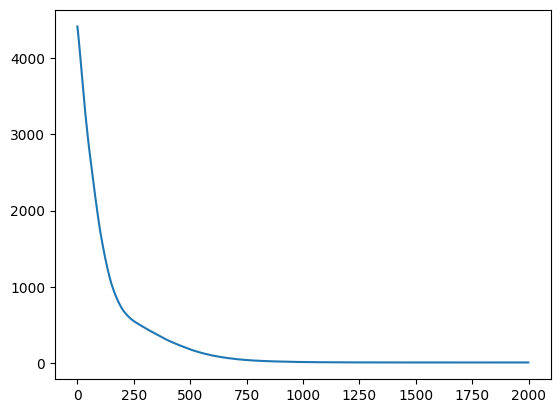

In [27]:
# diff. learning on a certain mesh input
import pytorch3d 
from pytorch3d.loss import chamfer_distance

opt_params = torch.randn(9)
opt_params[-3:] = torch.abs(opt_params[-3:])
opt_params[-2] = torch.rand(1) * 2 * torch.pi
opt_params[-1] = opt_params[-3] / 2  # make sure thickness is always less than arc radius
opt_params.requires_grad = True

optimizer = torch.optim.Adam([opt_params], 0.1) # 0.1 is a good lr, 1 is not good
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)  # Reduce LR every 500 steps

uv_coordinates = torch.rand((1000,2))
losses = []

points_tensor = points_tensor.view(1, -1, 3)


for _ in tqdm(range(2000)):
    optimizer.zero_grad()
    opt_points = primitive.hook(opt_params, uv_coordinates)
    opt_points = opt_points.view(1, -1, 3)
    
    loss = chamfer_distance(x = points_tensor, y = opt_points)
    loss = loss[0]
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_([opt_params], max_norm=1.0)
    optimizer.step()
    scheduler.step()

    with torch.no_grad(): 
        opt_params[-3:] = torch.abs(opt_params[-3:])
        if opt_params[-2] > 2*torch.pi:  # Is this is the error part??? seems to be true
            opt_params[-2] %= 2*torch.pi
        if opt_params[-1] > opt_params[-3]:
            opt_params[-1] = opt_params[-3] / 2  # Ensure length is always greater than the radius

    losses.append(loss.detach().item())
plt.plot(losses)
plt.show  # the results is not stable， but much better, don't know how to solve it ......


In [28]:
# compare the original mesh with the optimized mesh
points_tensor = points_tensor.reshape(-1, 1, 3)
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(opt_points.detach().numpy(), shading={'point_size':2, 'point_color':'green'})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.00…

1

In [29]:
# check opt_params by plotting original mesh with the points cloud got by opt_params
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

# opt_params is just the final parameters, so we have center, position, radius stored in opt_params
coordinates = torch.rand((1000, 2))
points = primitive.hook(opt_params, coordinates).detach().numpy()
plot.add_points(points, shading={'point_size':2, 'point_color':'green'})
# opt_params.detach().numpy()[-2] *= 180 / torch.pi
print(opt_params)  ## ground truth: [arc_radius, arc_angle, thickness] = [50, 270, 5]  , center = [0 0 0], orientation = [1 0 0] (x-axis)(normal to the circle face)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.00…

tensor([ 3.3356e-02,  1.7635e-01, -5.4202e-02, -1.0000e+00,  8.7571e-04,
        -2.5643e-03,  4.9836e+01,  4.7640e+00,  4.8413e+00],
       requires_grad=True)


In [30]:
# coordinates = torch.rand((1000, 2))
# check = primitive.hook(torch.tensor([0,0,0, 0,0,1, 15, 1.3*torch.pi, 4], dtype=torch.float32), coordinates).detach().numpy()
# mp.plot(check, return_plot=True, shading={'point_size':2})